<a href="https://colab.research.google.com/github/eunseochu/OB_1st/blob/main/%ED%95%B8%EC%A6%88%EC%98%A8_%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D_%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CHAPTER 3: 분류**

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

#### **3.1 MNIST**

**1) MNIST 데이터셋 내려받기 <br/>**
사이킷런에서 읽어 들인 데이터셋들은 일반적으로 비슷한 딕셔너리 구조를 가지고 있음
- 데이터셋을 설명하는 DESCR키
- 샘플이 하나의 행, 특성이 하나의 열로 구성된 배열을 가진 data키
- 레이블 배열을 담은 target 키

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

/usr/local/lib/python3.9/dist-packages/sklearn/datasets/_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

- 이미지가 70,000개 있고 각 이미지에는 784개의 특성이 있음 (28x28 픽셀)
- 개개의 특성은 단순히 0(흰색)부터 255(검은색)까지의 픽셀 강도를 나타냄

**2) 이미지 확인** <br/>
샘플의 특성 벡터를 추출해서 28x28 배열로 크기를 바꾸고 맷플롯립의 imshow() 함수를 사용

Saving figure some_digit_plot


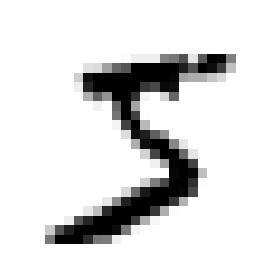

In [4]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")

save_fig("some_digit_plot")
plt.show()

**2-1) 레이블 확인** <br/>
숫자 5로 보이는 그림의 실제 레이블을 확인

In [5]:
y[0]

'5'

**2-2) 정수 변환** <br/>
대부분 머신러닝 알고리즘은 숫자를 기대하므로 y를 정수로 변환

In [6]:
y = y.astype(np.uint8)

**2-3) 테스트 세트 분리** <br/>
MNIST 데이터셋은 이미 훈련 세트와 테스트 세트로 나누어 놓았음
- 훈련 세트는 이미 섞여 있으므로 모든 교차 검증 폴드를 비슷하게 만듦
- 훈련 샘플 순서에 민감한 학습 알고리즘도 있기 때문에 성능이 나빠지는 문제를 방지할 수 있음

In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

#### **3.2 이진 분류기 훈련** <br/>
숫자 5만 식별하기 위해 '5'와 '5 아님' 두 개의 클래스를 구분할 수 있는 이진 분류기 생성

**1) 분류 작업을 위한 타깃 벡터 생성**

In [8]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

**2) 분류 모델 선택 후 훈련** <br/>
사이킷런의 SGDClassifier 클래스를 이용해 확률적 경사 하강법(SGD) 분류기로 시작
- 매우 큰 데이터셋을 효율적으로 처리하는 장점을 지님
- 한 번에 하나씩 훈련 샘플을 독립적으로 처리

In [9]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

**3) 훈련을 사용해 숫자 5 이미지 감지**

In [10]:
sgd_clf.predict([some_digit])

array([ True])

- 이미지가 5를 나타낸다고 추측함 (True)

#### **3.3 성능 측정** <br/>
분류기 평가는 회귀 모델보다 훨씬 어렵기 때문에 사용할 수 있는 성능 지표가 많음

**1) 교차 검증을 사용한 정확도 측정** <br/>
사이킷런이 제공하는 기능보다 교차 검증 과정을 더 많이 제어할 필요가 있는 경우 교차 검증 기능 직접 구현

In [11]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


- 클래스별 비율이 유지되도록 폴드를 만들기 위해 계층적 샘플링을 수행
- 매 반복에서 분류기 객체를 복제하여 훈련 폴드로 훈련시키고 테스트 폴드로 예측을 만듦
- 올바른 예측의 수를 세어 정확한 예측의 비율을 출력

**1-1) SGDClassifier 모델 평가** <br/>
cross_val_score() 함수로 폴드가 3개인 k-겹 교차 검증을 사용해 평가
- 훈련 세트를 k개로 나누고 각 폴드에 대해 예측을 만들고 평가하기 위해 나머지 폴드로 훈련시킨 모델을 사용 

In [12]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

- 모든 교차 검증 폴드에 대해 정확도가 95% 이상

**1-2) 더미 분류기와 비교** <br/>
모든 이미지를 '5 아님' 클래스로 분류하는 더미 분류기를 만들어 비교

In [13]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

**1-3) 모델의 정확도 추측**

In [14]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

- 정확도가 90% 이상으로 나옴
- 이미지가 10% 정도만 숫자 5이기 때문에 무조건 '5 아님'으로 예측 시 90%의 정확도가 나옴
- **불균형 데이터셋**을 다룰 때 정확도는 **분류기의 성능 측정 지표**로 적절하지 않음

**2) 오차 행렬** <br/>
분류기의 성능을 평가하는 더 좋은 방법
- 클래스 A의 샘플이 클래스 B로 분류된 횟수를 세는 아이디어
- 실제 타깃과 비교할 수 있도록 먼저 예측값을 만들어야 함
- 테스트 세트로 예측을 만들 수 있으나 사용해서는 안되며, 분류기가 출시 준비 마치고 난 후 사용해야 함
 - cross_val_predict() 함수 사용 가능

In [15]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

- cross_val_predcit() 함수는 k-겹 교차 검증을 수행하지만, <br/>
 평가 점수를 반환하지 않고 각 테스트 폴드에서 얻은 예측을 반환함
- 훈련 세트의 모든 샘플에 대한 깨끗한 예측을 얻게 됨

**2-1) confusion_matrix() 함수를 이용해 오차 행렬 생성** <br/>
타깃 클래스(y_train_5)와 예측 클래스(y_train_pred)를 넣고 호출

In [16]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

- 행은 실제 클래스를 나타내고 열은 예측한 클래스를 나타냄
 - 완벽한 분류기는 진짜 양성과 진짜 음성만 가지고 있으므로 오차 행렬의 주대각선만 0이 아닌 값
- 첫 번째 행은 '5 아님' 이미지(음성 클래스)에 대한 것
 - 53892개를 정확하게 분류했고 (진짜 음성), 나머지 687개는 잘못 분류함 (거짓 양성)
- 두 번째 행은 '5' 이미지(양성 클래스)에 대한 것
 - 1,325개를 잘모 분류했고 (거짓 음성), 나머지 4,096개를 정확히 분류 (진짜 양성)

In [17]:
y_train_perfect_predictions = y_train_5  # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

**2-2) 정밀도** <br/>
오차 행렬보다 더 요약된 지표가 필요할 때 사용하며, 양성 예측의 정확도
- TP / TP+FP
 - TP: 진짜 양성의 수, FP: 거짓 양성의 수
- 양성 샘플 하나만 예측하면 간단히 완벽한 정밀도를 얻을 수 있으나, <br/>
다른 모든 양성 샘플을 무시하므로 유용하진 않음

**2-3) 재현율**<br/>
정밀도와 함께 사용하며, 분류기가 정확하게 감지한 양성 샘플의 비율
- 민감도 또는 진짜 양성 비율(TPR)이라고도 함 
- TP / TP+FN
 - FN: 거짓 음성의 수

**3) 정밀도와 재현율** <br/>
정밀도와 재현율을 포함한 분류기의 지표를 계산하는 여러 함수 제공

In [18]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

- 5로 판별된 이미지 중 83%만 정확하며, 전체 숫자 5에서 83%만 감지

**3-1) F1 점수** <br/>
정밀도와 재현율을 F1 점수라고 하는 하나의 숫자로 만들면 편리하며, 특히 두 분류기를 비교할 때 사용
- 정밀도와 재현율의 조화 평균
- TP / TP+(FN+FP/2)

In [19]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

**3-2) 정밀도와 재현율** <br/>
정밀도와 재현율이 비슷한 분류기에는 F1 점수가 높지만, 바람직한 상황은 아님
 - 상황에 따라 정밀도가 중요할 수도 있고 재현율이 중요할 수도 있음
 - 정밀도를 올리면 재현율이 줄고 그 반대도 마찬가지이며, 이는 정밀도/재현율 트레이드오프라고 함

**4) 정밀도/재현율 트레이드오프** <br/>
SGDClassifier가 분류를 어떻게 결정하는지를 살펴보며 트레이드오프 이해

**4-1) 결정 함수** <br/>
SGDClassifier는 결정 함수를 사용하여 각 샘플의 점수를 계산함
- 점수가 임곗값보다 크면 샘플을 양성 클래스에 할당하고, 그렇지 않으면 음성 클래스에 할당
- 결정 임곗값에 따라 정밀도와 재현율이 달라짐 

**4-2) 사이킷런의 임곗값** <Br/>
사이킷런에서 임곗값을 직접 지정할 수는 없지만 예측에 사용한 점수는 확인할 수 있음
- 분류기의 predict() 메서드 대신 decision_function() 메서드를 호출하면 각 샘플 점수를 얻을 수 있음
- 해당 점수를 기반으로 원하는 임곗값을 정해 예측을 만들 수 있음

In [20]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [21]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [22]:
y_some_digit_pred

array([ True])

- SGDClassifier의 임곗값이 0이므로 위 코드는 predict() 메서드와 같은 결과 (True) 반환

**4-3) 임곗값 조정** <Br/>

In [23]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

- 임곗값을 높이면 재현율이 줄어듦

**4-4) 적절한 임곗값 지정** <br/>
cross_val_predict() 함수를 사용해 훈련 세트에 있는 모든 샘플의 점수를 구해야 함
- 예측 결과가 아닌 결정 함수를 반환받도록 지정

In [24]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

**4-5) 모든 임곗값에 대한 정밀도와 재현율 계산** <br/>
결정 점수로 precision_recall_curve() 함수를 사용하여 가능한 모든 임곗값에 대해 계산 가능

In [25]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

**4-6) 맷플롯립을 이용해 임곗값의 함수로 정밀도와 재현율 그리기**

Saving figure precision_recall_vs_threshold_plot


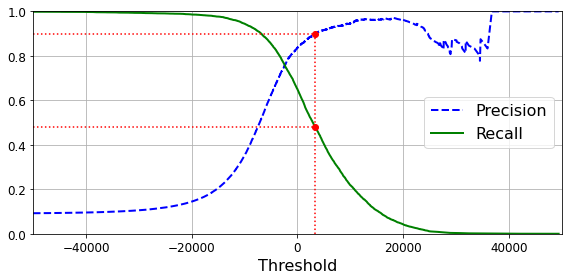

In [26]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown



recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
save_fig("precision_recall_vs_threshold_plot")                                              # Not shown
plt.show()

Saving figure precision_vs_recall_plot


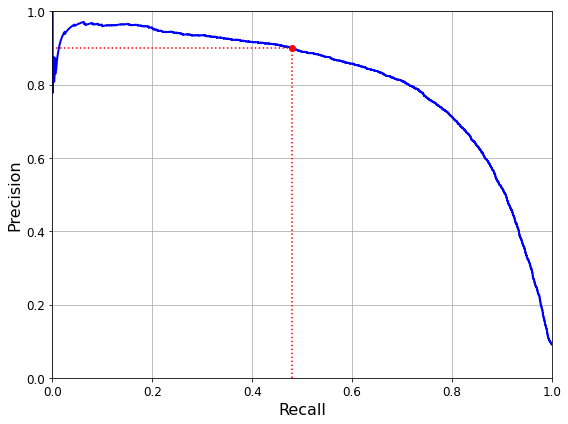

In [27]:
# 재현율에 대한 정밀도 곡선
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
save_fig("precision_vs_recall_plot")
plt.show()

- 재현율 80% 근처에서 정밀도가 급격하게 줄어들기 시작하며, 이 하강점 직전을 트레이드오프로 설정

**4-7) 임계값 설정** <br/>
정밀도 90%를 달성하는 것이 목표라면 최소한 정밀도 90%가 되는 가장 낮은 임계값 찾기

In [27]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

**4-8) 훈련 세트에 대한 예측 만들기** <br/>
예측을 만들기 위해서는 분류기의 predict() 메서드를 호출하는 대신 다음 코드 실행

In [28]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

**4-9) 예측에 대한 정밀도와 재현율 확인**

In [29]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [30]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

- 정밀도 90%를 달성한 분류기 생성
- 가상의 정밀도에 대해서도 분류기를 손쉽게 만들 수 있음

**5) ROC 곡선** <br/>
수신기 조작 특성 (ROC) 곡선은 이진 분류에서 널리 사용하며, 정밀도/재현율 곡선과 매우 비슷
- ROC 곡선은 정밀도에 대한 재현율 곡선이 아니고 거짓 양성 비율에 대한 진짜 양성 비율의 곡선
- 양성으로 잘못 분류된 음성 샘플의 비율이 FPR이며, 1에서 진짜 음성 비율(TNR)을 뺀 값
- 민감도에 대한 1-특이도(TNR) 그래프

**5-1) roc_curve() 함수 사용** <br/>
여러 임계값에서 TPR, FPR을 계산해야 함

In [31]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

**5-2) 맷플롯립을 사용해 TPR에 대한 FPR 곡선 그리기**

Saving figure roc_curve_plot


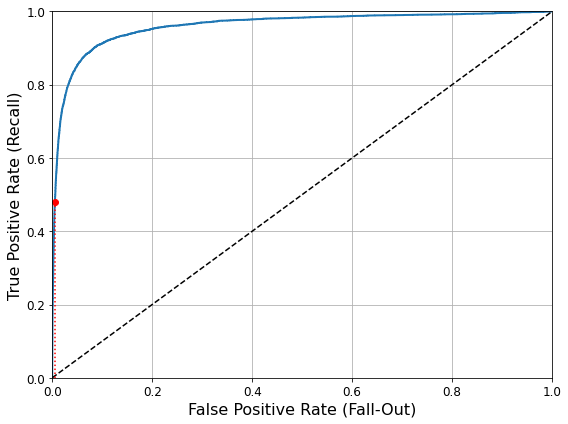

In [32]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                                    # Not shown
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           # Not shown
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   # Not shown
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  # Not shown
plt.plot([fpr_90], [recall_90_precision], "ro")               # Not shown
save_fig("roc_curve_plot")                                    # Not shown
plt.show()

- 재현율(TPR)이 높을수록 분류기가 만드는 거짓 양성이 늘어남
- 점선은 완전한 랜덤 분류기의 ROC 곡선을 뜻함
- 좋은 분류기는 점선에서 최대한 멀리 떨어져 있어야 함

**5-3) ROC의 AUC 계산** <br/>
곡선 아래의 면적을 측정하면 분류기들을 비교할 수 있음
- 완벽한 분류기는 ROC의 AUC가 1이고, 완전한 랜덤 분류기는 0.5

In [33]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

**5-4) SGDClassifier의 ROC 곡선과 ROC AUC 점수 비교** <Br/>
RandomForestClassifier을 훈련시킨 후 훈련 세트의 샘플에 대한 점수를 얻어야 함
- 작동 방식의 차이때문에 RandomForestClassifier는 predict_proba() 메서드 사용
- predict_proba()는 샘플이 행, 클래스가 열이고 샘플이 주어진 클래스에 속할 확률을 담은 배열 반환

In [34]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

**5-5) 양성 클래스 확률을 점수로 사용 후 ROC 곡선 그리기** <br/>
roc_curve() 함수는 레이블과 점수를 기대하지만 점수 대신 클래스 확률을 전달할 수도 있음
- 비교를 위해 첫 번째 ROC 곡선도 함께 그리기

In [35]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

Saving figure roc_curve_comparison_plot


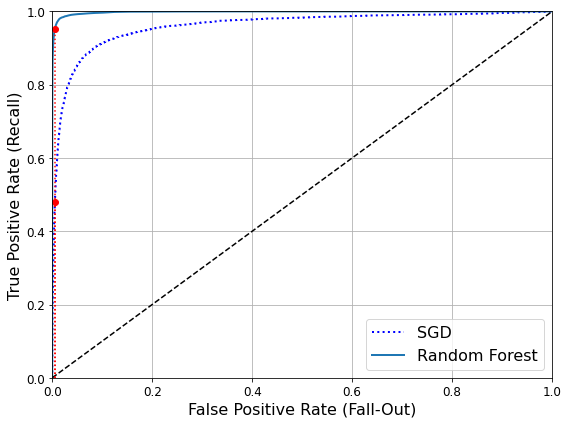

In [36]:
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
save_fig("roc_curve_comparison_plot")
plt.show()

- RandomForestClassifier의 ROC 곡선이 왼쪽 위 모서리에 더 가까워 SGDClassifier보다 좋아보임
- ROC AUC 점수도 훨씬 높음

**5-6) 정밀도 및 재현율 점수 계산** <br/>

In [37]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [39]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9905083315756169

In [40]:
recall_score(y_train_5, y_train_pred_forest)

0.8662608374838591

- 99.0%의 정밀도와 86.6%의 재현율이 나오므로 나쁘지 않은 결과 도출

#### **3.4 다중 분류** <br/>
다중 분류기(다항 분류기)는 둘 이상의 클래스 구별 가능

**1) 다중 클래스 분류 기법** <br/>
SGD 분류기, 랜덤 포레스트, 분류기 등의 일부 알고리즘은 여러 개의 클래스를 직접 처리 가능하지만, <br/>
로지스틱 회귀나 서포트 벡터 머신 분류기 등은 이진 분류만 가능
 - 이진 분류기를 여러 개 사용해 다중 클래스를 분류하는 기법도 존재

**1-1) OvR와 OvO** <br/>
특정 숫자 하나만 구분하는 숫자별 이진 분류기 10개를 훈련시켜 클래스가 10개인 숫자 이미지 분류 시스템 생성
- 이미지 분류 시 각 분류기의 결정 점수 중 가장 높은 것을 클래스로 선택하면 OvR(OvA) 전략
 - 대부분의 이진 분류 알고리즘에서 선호
- 0과 1 구별, 0과 2 구별, 1과 2 구별 등 각 숫자의 조합마다 이진 분류기를 훈련하면 OvO 전략
 - 클래스가 N개라면 Nx(N-1)/2개가 필요
 - 각 분류기의 훈련에 전체 훈련 세트 중 구별할 두 클래스에 해당하는 샘플만 필요

**1-2) 서포트 벡터 머신 분류기 테스트** <br/>
다중 클래스 분류 작업에 이진 분류 알고리즘을 선택하면 사이킷런이 자동으로 OvR 또는 OvO 실행

In [41]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(X_train[:1000], y_train[:1000]) # y_train, not y_train_5
svm_clf.predict([some_digit])

array([5], dtype=uint8)

- sklearn.svm.SVC 클래스를 사용
- 5를 구별한 타깃 클래스(y_train_5) 대신 0에서 9까지의 원래 타깃 클래스(y_train)를 사용해 훈련
- 그 후 예측을 하나 만들고, 내부에서 사이킷런이 OvO를 사용하여 10개의 이진 분류기를 훈련시키고 <br/>
각각의 결정 점수를 얻어 점수가 가장 높은 클래스를 선택

**1-3) decision_function() 메서드** <br/>
샘플 당 10개의 점수를 반환하며, 점수는 클래스마다 하나씩

In [42]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
         9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243]])

- 가장 높은 점수가 클래스 5에 해당하는 값

**2) OneVsOneClassifier나 OneVsRestClassifier** <br/>
사이킷런에서 OvO나 OVR을 사용하도록 강제하기 위해 사용
- 이진 분류기 인스턴스를 만들어 객체를 생성할 때 전달

In [43]:
# SVC 기반으로 OvR 전략을 사용하는 다중 분류기 생성

from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(X_train[:1000], y_train[:1000])
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [44]:
len(ovr_clf.estimators_)

10

**3) SGDClassifier(또는 RandomForestClassifier) 훈련**

In [45]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

- SGD 분류기는 직접 샘플을 다중 클래스로 분류할 수 있으므로 별도의 OvR이나 OvO 필요 X

**3-1) SGD 분류기의 decision_function() 메서드** <br/>
클래스마다 하나의 값을 반환하는  decision_function()으로 SGD 분류기가 클래스마다 부여한 점수 확인

In [46]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

- 분류기가 예측 결과에 강한 확신을 보이고 있음
- 대부분의 점수가 큰 음수지만, 클래스 5의 점수가 2412.5
- 573.5의 점수를 얻은 클래스 3을 의심

**3-2) 교차 검증** <br/>
분류기 평가에는 교차 검증을 사용하며, cross_val_score() 함수 사용

In [47]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

- 모든 테스트 폴드에서 84% 이상을 얻었으므로 나쁘지 않은 점수지만 성능을 더 높일 여지가 있음

In [48]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

- 입력의 스케일을 조정하여 정확도를 89% 이상으로 높임

#### **3.5 에러 분석** <br/>
데이터 준비 단계에서 가능한 선택 사항을 탐색하고, 여러 모델을 시도하고, <br/>
가장 좋은 몇 개를 골라 GridSearchCV를 사용해 하이퍼파라미터를 세밀하게 튜닝하고 가능한 자동화 진행
- 가능성이 높은 모델을 하나 찾았다는 가정 하에 모델의 성능 향상시킬 수 있는 방법에 대해 다룰 예정

**1) 오차 행렬** <br/>
만들어진 에러의 종류 분석하기 위해 오차 행렬을 살펴볼 수 있음
- cross_val_predict() 함수를 사용해 예측을 만들고 이전처럼 confusion_matrix() 함수 호출

In [49]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

**1-1) matshow() 함수** <br/>
오차 행렬을 맷플롯립의 matshow() 함수를 사용해 이미지로 표현하면 보기에 편리할 때가 많음

In [50]:
# since sklearn 0.22, you can use sklearn.metrics.plot_confusion_matrix()
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

Saving figure confusion_matrix_plot


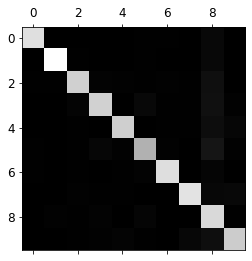

In [51]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_plot", tight_layout=False)
plt.show()

- 대부분의 이미지가 올바르게 분류되었음을 나타내는 주대각선에 있으므로 매우 좋아 보임
- 숫자 5가 다른 숫자보다 어두워보이는 이유는 숫자 5의 이미지가 적거나, <br/>
분류기가 숫자 5를 다른 숫자만큼 잘 분류하지 못한다는 뜻

**1-2) 그래프의 에러** <br/>
오차 행렬의 각 값에 대응되는 클래스 이미지 개수로 나누어 에러 비율을 비교
- 에러의 절대 개수가 아닌 비율을 비교
- 개수로 비교할 경우 이미지가 많은 클래스가 상대적으로 나쁘게 보임

In [52]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

**1-3) 분류기가 만든 에러 확인** <br/>
다른 항목은 그대로 유지하고 주대각선을 0으로 채워 그래프 그려서 확인
- 행은 실제 클래스를 나타내고 열은 예측한 클래스를 나타냄

Saving figure confusion_matrix_errors_plot


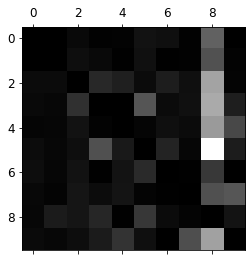

In [53]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_errors_plot", tight_layout=False)
plt.show()

- 클래스 8의 열이 상당히 밝으므로 많은 이미지가 8로 잘못 분류 되었음을 암시
- 그러나 클래스 8의 행은 그렇게 나쁘지 않으므로, 실제 8은 적절히 8로 분류되었음
- 오차 행렬이 반드시 대칭인 것은 아니며, 3과 5가 서로 많이 혼동되고 있는 것도 볼 수 있음

**2) 분류기의 성능 향상 방안** <br/>
오차 행렬을 분석시 분류기의 성능 향상 방안에 대한 통찰을 얻을 수 있음
- 8로 잘못 분류되는 것을 개선할 필요성이 있음을 확인
- 8처럼 보이는 숫자의 훈련 데이터를 더 많이 모아서 실제 8과 구분하도록 분류기를 학습시킬 수 있음
- 또한 분류기에 도움이 될만한 특성을 더 찾아볼 수 있음
 - 동심원의 수를 세는 알고리즘
 - 동심원 같은 어떤 패턴이 드러나도록 이미지 전처리

**3) 개개의 에러 분석** <br/>
분류기가 무슨 일을 하고, 왜 잘못되었는지에 대한 통찰을 얻을 수 있으나 더 어렵고 시간이 오래 걸림

In [55]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # This is equivalent to n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Saving figure error_analysis_digits_plot


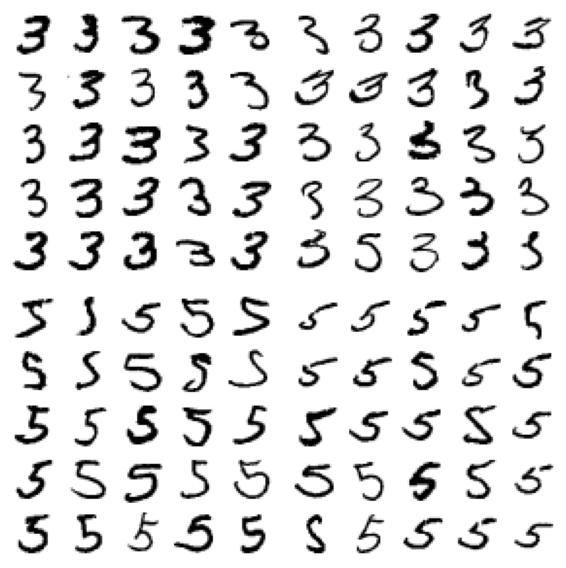

In [56]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
save_fig("error_analysis_digits_plot")
plt.show()

- 왼쪽의 5x5 블록 두 개는 3으로 분류된 이미지가 오른쪽 5x5 블록 두개는 5로 분류된 이미지
- 분류기가 잘못 분류한 숫자 중 일부는 잘못 쓰여져 있어 사람도 분류하기 어려워 보임
- 대부분의 잘못 분류된 이미지는 확실히 에러이며 분류기가 실수한 이유를 이해하기 어려움

**3-1) 오분류의 원인** <Br/>
원인은 선형 모델을 SGDClassifier을 사용했기 때문
 - 선형 분류기는 클래스마다 픽셀에 가중치를 할당하고, <Br/>
  새로운 이미지에 대해 단순히 픽셀 강도의 가중치 합을 클래스의 점수로 계산
 - 3과 5는 몇 개의 픽셀만 다르기 때문에 모델이 쉽게 혼동하게 됨

**3-2) 오분류 해결방법** <br/>
분류기는 이미지의 위치나 회전 방향에 매우 민감함
 - 3과 5의 주요 차이는 위쪽 선과 아래쪽 호를 이어주는 작은 직선의 위치
 - 숫자 3을 쓸 때 연결 부위가 조금 왼쪽으로 치우치면 분류기가 5로 분류하고, 반대도 마찬가지
 - 이미지를 중앙에 위치시키고 회전되어 있지 않도록 전처리하는 것을 권장

#### **3.6 다중 레이블 분류** <br/>
분류기가 샘플마다 여러 개의 클래스를 출력해야할 때가 존재
- 여러 개의 이진 꼬리표를 출력하는 분류 시스템을 다중 레이블 분류라고 부름
- ex. 얼굴 인식 분류기

**1) y_multilabel 배열 생성** <br/>
각 숫자 이미지에 두 개의 타깃 레이블이 담긴 y_multilabel 생성
- 첫 번째는 숫자가 큰 값 (7,8,9)인지 나타내고 두 번째는 홀수인지 나타냄

In [58]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

**2) 인스턴스를 만든 후 예측** <br/>
KNeighborsClassifier 인스턴스를 만들고 다중 타깃 배열을 사용하여 훈련시킴
- 레이블이 두개 출력됨

In [59]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

knn_clf.predict([some_digit])

array([[False,  True]])

- 올바르게 분류 됨
- 숫자 5는 크지 않고(False) 홀수(True)임

**3) 다중 레이블 분류기 평가** <br/>
다중 레이블 분류기를 평가하는 방법은 많으며, 적절한 지표는 프로젝트에 따라 다름

**3-1) F1 점수** <br/>
각 레이블의 F1 점수를 구하고 간단하게 평균 점수를 계산

In [60]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

- 실제로는 아닐 수 있지만 모든 레이블의 가중치가 같다고 가정

**3-2) 가중치** <br/>
레이블에 클래스의 지지도(타깃 레이블에 속한 샘플 수)를 가중치를 줄 수 있음
- average="weighted"로 설정

#### **3.7 다중 출력 분류** <br/>
다중 레이블 분류에서 한 레이블이 다중 클래스가 될 수 있도록 일반화
- 값을 두 개 이상 가질 수 있음

**1) 다중 출력 분류 시스템의 예시** <br/>
이미지에서 잡음을 제거하는 시스템이 다중 출력 다중 클래스 분류 중 하나
- 잡음이 많은 숫자 이미지를 입력으로 받고, 깨끗한 숫자 이미지를 픽셀의 강도를 담은 배열로 출력
- 분류기의 출력이 다중 레이블(픽셀당 한 레이블)이고 각 레이블은 값을 여러 개 가짐(0부터 255까지 픽셀 강도)

**2) 픽셀 강도에 잡음 추가** <br/>
MNIST 이미지에서 추출한 훈련 세트와 테스트 세트에 넘파이의 randint() 함수를 사용
- 타깃 이미지는 원본 이미지

In [61]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

**3) 분류기 훈련 후 이미지 잡음 제거** <Br/>
테스트 세트에서 이미지를 하나 선택한 후 분류기를 훈련시켜 이미지를 깨끗하게 만듦

In [63]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

Saving figure noisy_digit_example_plot


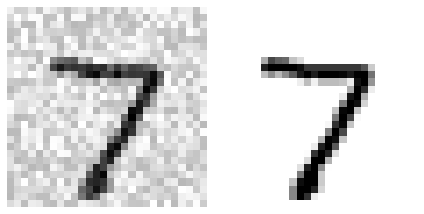

In [64]:
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
save_fig("noisy_digit_example_plot")
plt.show()

- 왼쪽은 잡음이 섞인 입력 이미지며, 오른쪽이 깨끗한 타깃 이미지

Saving figure cleaned_digit_example_plot


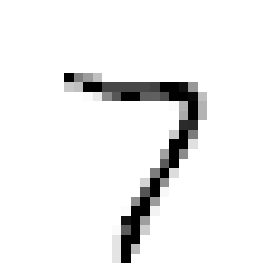

In [65]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)
save_fig("cleaned_digit_example_plot")

- 타깃과 매우 비슷한 결과 도출